# **Modelo 1D para la membrana de una Batería de Vanadio Flujo Redox Híbrida**

In [ ]:
pip install scipy_dae

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00


In [21]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy_dae.integrate import solve_dae # Solver para el sistema DAE obtenido

# **Definición de las constantes**

In [25]:

#Constantes Físicas fundamentales para el modelo

F = 96485.3       # C/mol (Constante de Faraday)
R = 8.314         # J/(mol·K) (Constante de los gases)
T = 298.15        # K (Temperatura) condiciones estándar
RT = (R * T)      # J/mol

# Parámetros de la Membrana
L = 127e-6        # m (Espesor de la membrana, arbritario) #Modificable
eps_m = 0.28      # (Porosidad/fracción de volumen de la membrana, arbritario) #Modificable
c_f = 1200.0      # mol/m³ (Concentración de sitios fijos SO3-, arbritario pero similar al paper de Knehr y la Tesis de Catalina) #Modificable
z_f = -1.0          # - (Carga de los sitios fijos)

# Parámetros de Especies , difusibidades sacadas directamente de Knehr
# Especie 1: Protones (H+)
z_H = 1.0
D_H_membrana = 5e-10 #Un poco menor, para agilizar la obtención de condiciones iniciales
D_H_eff = D_H_membrana * eps_m**(1.5) # m²/s (Difusividad efectiva, se aplica corrección por porosidad)

# Especie 2: Bisulfato (HSO4-)
z_HSO4 = -1.0
D_HSO4_membrana = 4e-11
D_HSO4_eff = D_HSO4_membrana * eps_m**(1.5)

# Especie 3: Vanadio IV (VO2+)
z_VO = 2.0          # - (Carga del Vanadio IV)
D_VO_membrana = 5.0e-12
D_VO_eff = D_VO_membrana * eps_m**(1.5)

# Especie 4: Vanadio V (VO2+)
z_VO2 = 1.0         # - (Carga del Vanadio V)
D_VO2_membrana = 1.17e-12
D_VO2_eff = D_VO2_membrana * eps_m**(1.5)

# Parámetros de la Celda para SOC
A_mem = 0.01        # m² (Área activa de la membrana/celda, arbritario) #Modificable
V_tank = 0.001      # m³ (Volumen del electrolito en el tanque del cátodo, arbritario, para esta escala definimos 1 L) #Modificable
C_total_V = 1400.0  # mol/m³ (Concentración total de Vanadio, arbritario)  #Modificable
SOC_inicial = 0.5   # 50% de SOC

# Inicialización al valor de SOC establecido
c_H_catolito = 1500.0   # mol/m³ (Concentración de H+ en el cátodo) #Modificable
c_VO_catolito = C_total_V * (1 - SOC_inicial) # 700.0 mol/m³
c_VO2_catolito = C_total_V * SOC_inicial      # 700.0 mol/m³

# Parámetros de Simulación
N = 100             # Número de nodos #Modificable pero definido en 100 para evitar demoras excesivas
dx = L / N          # m (Ancho de cada CV)
x_nodos = np.linspace(dx/2, L - dx/2, N) # Coordenadas de los centros
j_appl = -50.0      # A/m² (Densidad de corriente aplicada) #Modificable

delta_phi_D = -0.001 # V (Salto de potencial de Donnan, de electrolito a membrana)

# CÁLCULO DE BCs para Cátodo (x=0) usando las CONCENTRACIONES INICIALES
c_H_borde_izq = c_H_catolito * np.exp(-z_H * F * delta_phi_D / RT)
c_VO_borde_izq = c_VO_catolito * np.exp(-z_VO * F * delta_phi_D / RT)
c_VO2_borde_izq = c_VO2_catolito * np.exp(-z_VO2 * F * delta_phi_D / RT)
phi_borde_izq = 0.0      # V (Potencial de referencia)

# Guardar j_appl global para restaurarla después
j_appl_global = j_appl

print(f"Parámetros definidos: N={N}, dx={dx:.2e} m")
print(f"Especies incluidas: H+, HSO4-, VO2+, VO2+ (4N en membrana) + 2 Concentraciones de Bulk")

Parámetros definidos: N=100, dx=1.27e-06 m
Especies incluidas: H+, HSO4-, VO2+, VO2+ (4N en membrana) + 2 Concentraciones de Bulk


# **Definición de las funciones**

In [23]:
def calcular_flujos(c_H_P, c_H_adj, phi_P, phi_adj, c_HSO4_P, c_HSO4_adj,
                    c_VO_P, c_VO_adj, c_VO2_P, c_VO2_adj):
    #Con esta función se calculan los flujos de las caras de nuestros nodos

    # Promedios en la cara
    c_H_cara = (c_H_P + c_H_adj) / 2.0
    c_HSO4_cara = (c_HSO4_P + c_HSO4_adj) / 2.0
    c_VO_cara = (c_VO_P + c_VO_adj) / 2.0
    c_VO2_cara = (c_VO2_P + c_VO2_adj) / 2.0

    # Gradientes en la cara
    grad_c_H = (c_H_adj - c_H_P) / dx
    grad_c_HSO4 = (c_HSO4_adj - c_HSO4_P) / dx
    grad_c_VO = (c_VO_adj - c_VO_P) / dx
    grad_c_VO2 = (c_VO2_adj - c_VO2_P) / dx
    grad_phi = (phi_adj - phi_P) / dx

#En esta sección se usan las ecuaciones discretizadas con el método de volúmenes finitos
    # Flujo Nernst-Planck para H+
    N_H = -D_H_eff * grad_c_H - (D_H_eff * z_H * F / RT) * c_H_cara * grad_phi

    # Flujo Nernst-Planck para HSO4-
    N_HSO4 = -D_HSO4_eff * grad_c_HSO4 - (D_HSO4_eff * z_HSO4 * F / RT) * c_HSO4_cara * grad_phi

    #  Flujo Nernst-Planck para VO2+ (Vanadio IV)
    N_VO = -D_VO_eff * grad_c_VO - (D_VO_eff * z_VO * F / RT) * c_VO_cara * grad_phi

    # Flujo Nernst-Planck para VO2+ (Vanadio V)
    N_VO2 = -D_VO2_eff * grad_c_VO2 - (D_VO2_eff * z_VO2 * F / RT) * c_VO2_cara * grad_phi

    # Corriente Iónica Total en la cara (suma de todos los iones : V4,V5 HSO4 y los protones)
    j_l = F * (z_H * N_H + z_HSO4 * N_HSO4 + z_VO * N_VO + z_VO2 * N_VO2)

    # Devolvemos los flujos de las especies diferenciales y la corriente
    return N_H, N_VO, N_VO2, j_l

# El vector de estado ahora tiene 4*N + 2 variables
def residual_EN(t, y, yp):
    #Residuo del sistema DAE (Conservación de masa en membrana y SOC en tanque).

    # 1. Desempaquetar vectores
    c_H = y[0:N].copy()          # Diferencial
    c_VO = y[N:2*N].copy()       # Diferencial
    c_VO2 = y[2*N:3*N].copy()    # Diferencial
    phi = y[3*N:4*N]             # Algebraico

    # NUEVAS VARIABLES DE ESTADO (Concentraciones de Bulk/Tanque)
    C_VO_bulk = y[4*N]           # Diferencial
    C_VO2_bulk = y[4*N + 1]      # Diferencial

    dc_H_dt = yp[0:N]
    dc_VO_dt = yp[N:2*N]
    dc_VO2_dt = yp[2*N:3*N]

    dC_VO_bulk_dt = yp[4*N]
    dC_VO2_bulk_dt = yp[4*N + 1]

    # Aplicar un piso a las concentraciones para evitar valores negativos y resolver problemas en las curvas
    c_H[c_H < 1e-6] = 1e-6
    c_VO[c_VO < 1e-6] = 1e-6
    c_VO2[c_VO2 < 1e-6] = 1e-6

    if C_VO_bulk < 1e-6:
        C_VO_bulk = 1e-6
    if C_VO2_bulk < 1e-6:
        C_VO2_bulk = 1e-6

    num_vars = 4 * N + 2
    res = np.zeros(num_vars)
    c_HSO4 = np.zeros(N)

    # 2. Calcular variables algebraicas (c_HSO4) en todos los nodos
    for P in range(N):
        # Ecuación EN completa
        c_HSO4[P] = c_H[P] + z_VO * c_VO[P] + z_VO2 * c_VO2[P] - c_f

        if c_HSO4[P] < 0:
            c_HSO4[P] = 1e-6 # Piso para HSO4

    # 3. Definición de los Nodos Internos (P = 1 a N-2)
    for P in range(1, N - 1):
        # Flujos en cara este (e) y oeste (w)
        N_H_e, N_VO_e, N_VO2_e, j_l_e = calcular_flujos(
            c_H[P], c_H[P+1], phi[P], phi[P+1], c_HSO4[P], c_HSO4[P+1],
            c_VO[P], c_VO[P+1], c_VO2[P], c_VO2[P+1])

        N_H_w, N_VO_w, N_VO2_w, j_l_w = calcular_flujos(
            c_H[P-1], c_H[P], phi[P-1], phi[P], c_HSO4[P-1], c_HSO4[P],
            c_VO[P-1], c_VO[P], c_VO2[P-1], c_VO2[P])

        # Ecuación Diferencial: Conservación de H+ (res[P])
        res[P] = eps_m * dc_H_dt[P] * dx + (N_H_e - N_H_w)

        # Ecuación Diferencial: Conservación de VO2+ (res[N+P])
        res[N + P] = eps_m * dc_VO_dt[P] * dx + (N_VO_e - N_VO_w)

        # Ecuación Diferencial: Conservación de VO2+ (res[2N+P])
        res[2*N + P] = eps_m * dc_VO2_dt[P] * dx + (N_VO2_e - N_VO2_w)

        # Ecuación Algebraica: Conservación de Corriente (res[3N+P])
        res[3*N + P] = j_l_e - j_l_w


    # 4. Condiciones de Borde (BCs de la Membrana)

    # CÁLCULO DE BCs DINÁMICAS (usando las nuevas variables de Bulk)
    c_H_borde_izq_dyn = c_H_catolito * np.exp(-z_H * F * delta_phi_D / RT)
    c_VO_borde_izq_dyn = C_VO_bulk * np.exp(-z_VO * F * delta_phi_D / RT)
    c_VO2_borde_izq_dyn = C_VO2_bulk * np.exp(-z_VO2 * F * delta_phi_D / RT)

    # --- Nodo P=0 (Lado Izquierdo, x=0, Interfaz Cátodo) ---
    res[0] = c_H[0] - c_H_borde_izq_dyn        # BC 1: c_H (Dirichlet)
    res[N] = c_VO[0] - c_VO_borde_izq_dyn      # BC 2: c_VO (Dirichlet - DINÁMICA)
    res[2*N] = c_VO2[0] - c_VO2_borde_izq_dyn  # BC 3: c_VO2 (Dirichlet - DINÁMICA)
    res[3*N] = phi[0] - phi_borde_izq          # BC 4: phi (Dirichlet)

    # --- Nodo P=N-1 (Lado Derecho, x=L, Interfaz Ánodo) ---
    # Flujos en la cara oeste (w) del último nodo
    N_H_w_borde, N_VO_w_borde, N_VO2_w_borde, j_l_w_borde = calcular_flujos(
        c_H[N-2], c_H[N-1], phi[N-2], phi[N-1], c_HSO4[N-2], c_HSO4[N-1],
        c_VO[N-2], c_VO[N-1], c_VO2[N-2], c_VO2[N-1])

    # BC 5: c_H es Neumann (Flujo de H+ = j_appl / F) - DIFERENCIAL
    N_H_e_borde = j_appl / (z_H * F)
    acumulacion_H_borde = eps_m * dc_H_dt[N-1] * dx
    flujo_neto_H_borde = (N_H_e_borde - N_H_w_borde)
    res[N - 1] = acumulacion_H_borde + flujo_neto_H_borde

    # BC 6: c_VO es Neumann (Flujo Cero, simplificación del modelo) - DIFERENCIAL (revertido a la versión estable)
    N_VO_e_borde = 0.0
    acumulacion_VO_borde = eps_m * dc_VO_dt[N-1] * dx
    flujo_neto_VO_borde = (N_VO_e_borde - N_VO_w_borde)
    res[2*N - 1] = acumulacion_VO_borde + flujo_neto_VO_borde

    # BC 7: c_VO2 es Neumann (Flujo Cero, simplificación del modelo) - DIFERENCIAL (revertido a la versión estable)
    N_VO2_e_borde = 0.0
    acumulacion_VO2_borde = eps_m * dc_VO2_dt[N-1] * dx
    flujo_neto_VO2_borde = (N_VO2_e_borde - N_VO2_w_borde)
    res[3*N - 1] = acumulacion_VO2_borde + flujo_neto_VO2_borde

    # BC 8: phi es Neumann (Corriente iónica = j_appl) - ALGEBRAICA
    res[4*N - 1] = j_appl - j_l_w_borde


    # 5. Ecuaciones del SOC

    # Usamos la Ley de Faraday. Un e- por mol de Vanadio.

    rate_abs = np.abs(j_appl) * A_mem / F / V_tank

    if j_appl < 0: # Carga

        res[4*N] = dC_VO_bulk_dt + rate_abs


        res[4*N + 1] = dC_VO2_bulk_dt - rate_abs

    else: # Descarga

        res[4*N] = dC_VO_bulk_dt - rate_abs


        res[4*N + 1] = dC_VO2_bulk_dt + rate_abs


    return res

print("Funciones de residual y flujos (con SOC dinámico y N=0) definidas.")

Funciones de residual y flujos (con SOC dinámico y N=0) definidas.


# **Cálculo de las condiciones iniciales**

In [26]:

j_appl = j_appl_global

def encontrar_condiciones_iniciales(j_inicial):

    num_vars = 4 * N + 2

    def residual_ss(y_ss):
        global j_appl
        j_appl_backup = j_appl
        j_appl = j_inicial # Usar j=0 para equilibrio

        yp_ss = np.zeros(num_vars)
        res_ss = residual_EN(0, y_ss, yp_ss)

        j_appl = j_appl_backup # Restaurar j_appl
        return res_ss

    # Supociciones iniciales

    # 1. c_H (membrana)
    c_H_neutro = c_f / z_H
    c_H_guess = np.linspace(c_H_borde_izq, c_H_neutro, N)

    # 2. c_VO (membrana) - Constante en este modelo para CI de j=0
    c_VO_guess = np.full(N, c_VO_borde_izq)

    # 3. c_VO2 (membrana) - Constante en este modelo para CI de j=0
    c_VO2_guess = np.full(N, c_VO2_borde_izq)

    # 4. phi (membrana)
    phi_guess = np.linspace(phi_borde_izq, phi_borde_izq + 0.01, N)

    # 5. C_VO_bulk (tanque) - Usa la concentración inicial y determina la de la membrana
    C_VO_bulk_guess = np.array([c_VO_catolito])

    # 6. C_VO2_bulk (tanque) - Usa la concentración inicial y determina la de la membrana
    C_VO2_bulk_guess = np.array([c_VO2_catolito])

    # Juntar todas las especies que estamos simulando
    y_guess = np.concatenate((c_H_guess, c_VO_guess, c_VO2_guess, phi_guess,
                              C_VO_bulk_guess, C_VO2_bulk_guess))

    print(f"Calculando condiciones iniciales consistentes (t=0, j={j_inicial} A/m²)...")
    # Resolver el sistema algebraico
    sol_ic = root(residual_ss, y_guess, method='lm')

    if not sol_ic.success:
        print(f"Error: {sol_ic.message}")
        raise RuntimeError("No se pudieron encontrar las CI consistentes.")

    print("Condiciones iniciales (y0) encontradas.") #Aseguramos que se llega a un resultado satisfactorio

    # yp0 es cero por definición (estado estacionario)
    yp0 = np.zeros(num_vars)

    return sol_ic.x, yp0

# Calcular y0 y yp0 para t=0 (en equilibrio, j_appl=0)
y0_consistente, yp0_consistente = encontrar_condiciones_iniciales(j_inicial=0.0)

# Restaurar la j_appl para la simulación transitoria
j_appl = j_appl_global

Calculando condiciones iniciales consistentes (t=0, j=0.0 A/m²)...
Condiciones iniciales (y0) encontradas.


# **Solver Dae y Gráficos**

<>:70: SyntaxWarning: invalid escape sequence '\p'
<>:70: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-881150833.py:70: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_nodos, phi_final, 'go-', markersize=4, label=f'$\phi_e$ (t={sol.t[-1]}s)')
/usr/local/lib/python3.12/dist-packages/scipy_dae/integrate/_dae/dae.py:408: UserWarning: The following arguments have no effect for a chosen solver: `algebraic_vars_idx`.
  solver = method(fun, t0, y0, yp0, t_bound, vectorized=vectorized, **options)


Iniciando simulación transitoria (t=3600s, j=-50.0 A/m²)...

¡Simulación completada con éxito!


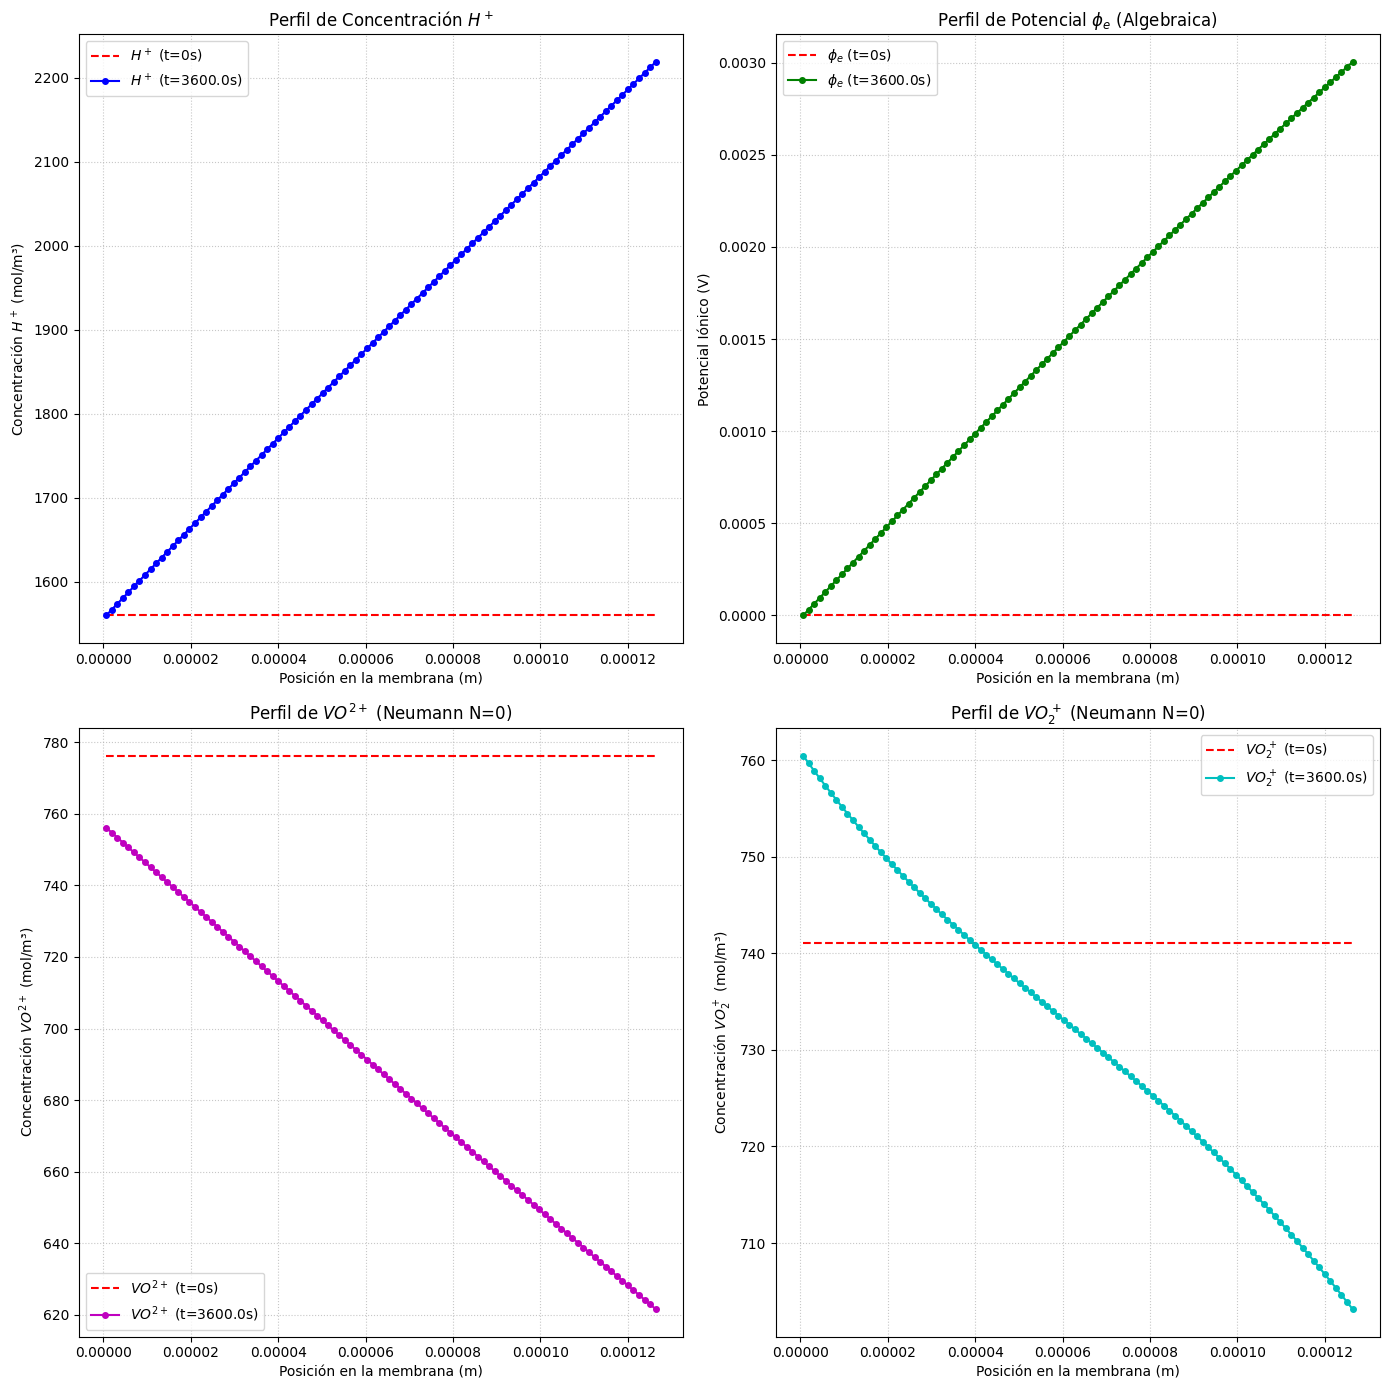

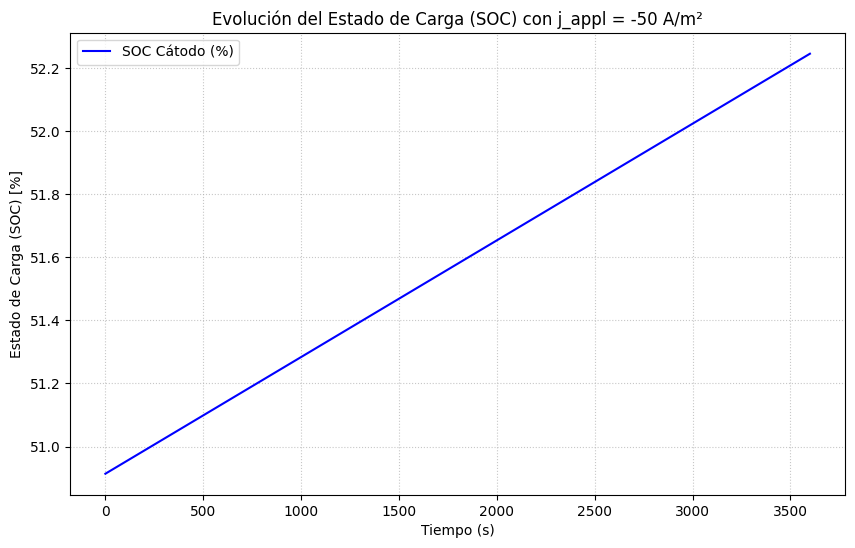

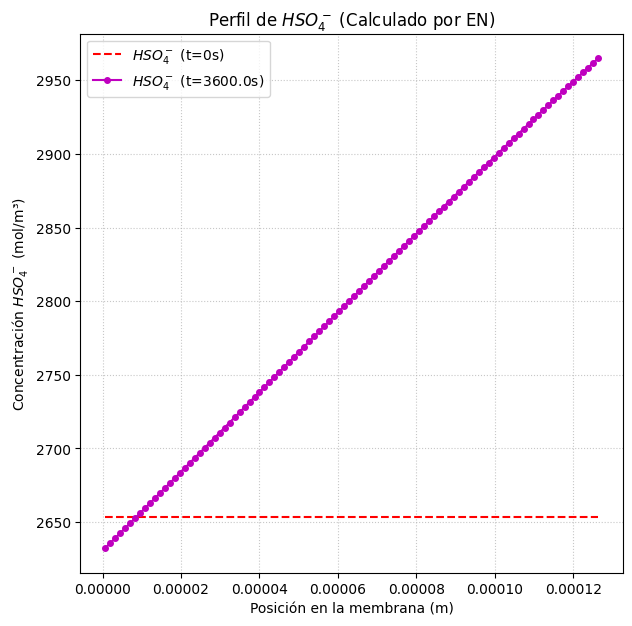

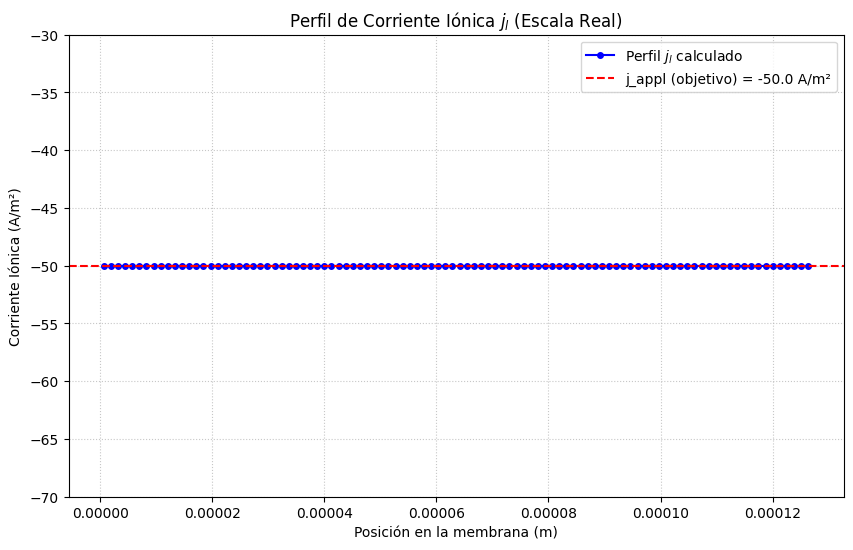

In [27]:
#Definición del tiempo de similación

t_span = (0, 3600) #Se puede modificar para evualuar como varía a lo largo de diferentes tiempos.Mientras más grande t más lineal se vuelve el perfil
t_eval = np.linspace(t_span[0], t_span[1], 100)

#Hasta acá se puede modificar

N_vars_mem = 4 * N
indices_algebraicos = list(range(3 * N, 4 * N))


print(f"Iniciando simulación transitoria (t={t_span[1]}s, j={j_appl} A/m²)...\n")


# Resolver el DAE
sol = solve_dae(residual_EN, t_span, y0_consistente, yp0_consistente,
                t_eval=t_eval,
                algebraic_vars_idx=indices_algebraicos,
                method="Radau",
                rtol=1e-5,
                atol=1e-8)

if not sol.success:
    print(f"La simulación DAE falló. Mensaje: {sol.message}")
else:
    print("¡Simulación completada con éxito!")

    # Extracción de Resultados del Tanque (SOC)
    C_VO_bulk_series = sol.y[4*N, :]
    C_VO2_bulk_series = sol.y[4*N + 1, :]

    # Cálculo del SOC
    SOC_series = C_VO2_bulk_series / C_total_V * 100

    # Estado final de la membrana
    sol_inicial = y0_consistente
    sol_final = sol.y[:, -1]

    c_H_inicial = sol_inicial[0:N]
    c_H_final = sol_final[0:N]

    c_VO_inicial = sol_inicial[N:2*N]
    c_VO_final = sol_final[N:2*N]

    c_VO2_inicial = sol_inicial[2*N:3*N]
    c_VO2_final = sol_final[2*N:3*N]

    phi_inicial = sol_inicial[3*N:4*N]
    phi_final = sol_final[3*N:4*N]

    c_HSO4_inicial = c_H_inicial + z_VO * c_VO_inicial + z_VO2 * c_VO2_inicial - c_f
    c_HSO4_final = c_H_final + z_VO * c_VO_final + z_VO2 * c_VO2_final - c_f

   #Generación de gráficos
    plt.figure(figsize=(14, 14))

    # Gráfico 1: Concentración H+
    plt.subplot(2, 2, 1)
    plt.plot(x_nodos, c_H_inicial, 'r--', label=r'$H^+$ (t=0s)')
    plt.plot(x_nodos, c_H_final, 'bo-', markersize=4, label=f'$H^+$ (t={sol.t[-1]}s)')
    plt.xlabel('Posición en la membrana (m)')
    plt.ylabel('Concentración $H^+$ (mol/m³)')
    plt.legend()
    plt.title(r'Perfil de Concentración $H^+$')
    plt.grid(True, linestyle=':', alpha=0.7)

    # Gráfico 2: Potencial Iónico phi
    plt.subplot(2, 2, 2)
    plt.plot(x_nodos, phi_inicial, 'r--', label=r'$\phi_e$ (t=0s)')
    plt.plot(x_nodos, phi_final, 'go-', markersize=4, label=f'$\phi_e$ (t={sol.t[-1]}s)')
    plt.xlabel('Posición en la membrana (m)')
    plt.ylabel('Potencial Iónico (V)')
    plt.legend()
    plt.title(r'Perfil de Potencial $\phi_e$ (Algebraica)')
    plt.grid(True, linestyle=':', alpha=0.7)

    # Gráfico 3: Concentración VO2+
    plt.subplot(2, 2, 3)
    plt.plot(x_nodos, c_VO_inicial, 'r--', label=r'$VO^{2+}$ (t=0s)')
    plt.plot(x_nodos, c_VO_final, 'mo-', markersize=4, label=f'$VO^{{2+}}$ (t={sol.t[-1]}s)')
    plt.xlabel('Posición en la membrana (m)')
    plt.ylabel('Concentración $VO^{2+}$ (mol/m³)')
    plt.legend()
    plt.title(r'Perfil de $VO^{2+}$ (Neumann N=0)')
    plt.grid(True, linestyle=':', alpha=0.7)

    # Gráfico 4: Concentración VO2+
    plt.subplot(2, 2, 4)
    plt.plot(x_nodos, c_VO2_inicial, 'r--', label=r'$VO_2^+$ (t=0s)')
    plt.plot(x_nodos, c_VO2_final, 'co-', markersize=4, label=f'$VO_2^+$ (t={sol.t[-1]}s)')
    plt.xlabel('Posición en la membrana (m)')
    plt.ylabel('Concentración $VO_2^+$ (mol/m³)')
    plt.legend()
    plt.title(r'Perfil de $VO_2^+$ (Neumann N=0)')
    plt.grid(True, linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # SOC a lo largo del tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(sol.t, SOC_series, 'b-', label='SOC Cátodo (%)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Estado de Carga (SOC) [%]')
    plt.legend()
    plt.title(r'Evolución del Estado de Carga (SOC) con j_appl = -50 A/m²')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

    # Perfil de HSO4-
    plt.figure(figsize=(7, 7))
    plt.plot(x_nodos, c_HSO4_inicial, 'r--', label=r'$HSO_4^-$ (t=0s)')
    plt.plot(x_nodos, c_HSO4_final, 'mo-', markersize=4, label=f'$HSO_4^-$ (t={sol.t[-1]}s)')
    plt.xlabel('Posición en la membrana (m)')
    plt.ylabel('Concentración $HSO_4^-$ (mol/m³)')
    plt.legend()
    plt.title(r'Perfil de $HSO_4^-$ (Calculado por EN)')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

    # Gráfico de Corriente para evaluar que se mantega constante a lo largo de todo el dominio.Si se saca plt.ylimit se ven variaciones en el orden de e-6 (despreciables)
    j_l_profile = np.zeros(N)
    for P in range(N - 1):
        _ , _ , _ , j_l_e = calcular_flujos(
            c_H_final[P], c_H_final[P+1], phi_final[P], phi_final[P+1],
            c_HSO4_final[P], c_HSO4_final[P+1],
            c_VO_final[P], c_VO_final[P+1], c_VO2_final[P], c_VO2_final[P+1])
        j_l_profile[P] = j_l_e
    j_l_profile[N-1] = j_appl

    plt.figure(figsize=(10, 6))

    plt.plot(x_nodos, j_l_profile, 'bo-', markersize=4, label=r'Perfil $j_l$ calculado')
    plt.axhline(j_appl, color='r', linestyle='--', label=f'j_appl (objetivo) = {j_appl} A/m²')
    plt.ylim(j_appl - 20, j_appl + 20)
    plt.xlabel('Posición en la membrana (m)')
    plt.ylabel('Corriente Iónica (A/m²)')
    plt.legend()
    plt.title(r'Perfil de Corriente Iónica $j_l$ (Escala Real)')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()